In [1]:
# Importar librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler



2025-03-18 20:50:03.469260: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-18 20:50:03.493710: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
device = "/GPU:0" if tf.test.is_gpu_available() else "/CPU:0"
print(f"Usando dispositivo: {device}")

print("GPU disponible:", tf.test.is_gpu_available())


print(tf.config.list_physical_devices('GPU'))


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Usando dispositivo: /CPU:0
GPU disponible: False
[]


In [2]:
# Cargar datos
df = pd.read_csv("ipsaCompleto.csv")  # Debe tener "Date" y "Price"
df["Fecha"] = pd.to_datetime(df["Fecha"])
df = df.sort_values("Fecha")  # Asegurar orden temporal

In [4]:
# Normalizar precios entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
df["Valor IPSA"] = scaler.fit_transform(df["Valor IPSA"].values.reshape(-1, 1))

# Crear datos de entrenamiento con ventanas de tiempo
def crear_secuencias(datos, ventana=30):
    X, y = [], []
    for i in range(len(datos) - ventana):
        X.append(datos[i:i+ventana])
        y.append(datos[i+ventana])
    return np.array(X), np.array(y)

ventana = 30  # Usar los últimos 30 días para predecir
X, y = crear_secuencias(df["Valor IPSA"].values, ventana)

# Dividir datos en entrenamiento y prueba
X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
y_train, y_test = y[:int(0.8*len(y))], y[int(0.8*len(y)):]

# Reshape para LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [5]:
# Definir modelo LSTM
modelo = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compilar modelo
modelo.compile(optimizer="adam", loss="mean_squared_error")

# Entrenar modelo
modelo.fit(X_train, y_train, batch_size=16, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20


/nix/store/870rhfr0vkcgjd15kzp3w72gv061wn4p-python3-3.11.11-env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0053 - val_loss: 0.0024
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 7.3538e-04 - val_loss: 5.4561e-04
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.7638e-04 - val_loss: 9.2581e-04
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.4080e-04 - val_loss: 3.7953e-04
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.5141e-04 - val_loss: 0.0012
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.6022e-04 - val_loss: 5.9306e-04
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.7305e-04 - val_loss: 4.7753e-04
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.0923e-04 - val_loss: 5.8647e-04
Epoch 9/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.7383e-04 - val_loss: 5.5806e-04
Epoch 10/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.9315e-04 - val_loss: 2.7103e-04
Epoch 11/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.1172e-04 - val_lo

In [7]:
# Hacer predicción para mañana
ultimos_datos = df["Valor IPSA"].values[-ventana:].reshape(1, ventana, 1)
prediccion = modelo.predict(ultimos_datos)
prediccion_real = scaler.inverse_transform(prediccion.reshape(-1, 1))

print(f"Predicción del IPSA para mañana: {prediccion_real[0][0]:.2f}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Predicción del IPSA para mañana: 7129.14


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


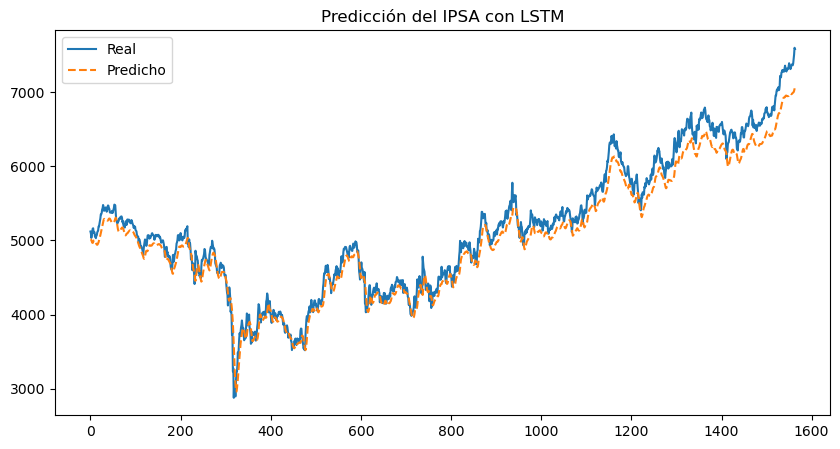

In [8]:
# Graficar predicciones vs. reales
predicciones = modelo.predict(X_test)
predicciones_real = scaler.inverse_transform(predicciones.reshape(-1, 1))
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.plot(y_test_real, label="Real")
plt.plot(predicciones_real, label="Predicho", linestyle="dashed")
plt.legend()
plt.title("Predicción del IPSA con LSTM")
plt.show()